# Multi-Layer Perceptron (MLP), MNIST
---
<font color='cyan'> Responsible TA: AmirHossein Razlighi </font>

In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

This is a well-known and famous problem in the machine learning community! We try to train our network to recognize handwritten digits from 0 to 9. We use the famous MNIST dataset for this purpose. The dataset contains 60,000 training images and 10,000 testing images. Each image is a 28x28 grayscale image. We will use the MLP to classify the images.

Let's proceed with the excersise!

In [3]:
# Run this code if you are trying to run the notebook locally
!python3 -m venv ./venv
!source ./venv/bin/activate

Error: Command '['/content/venv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: ./venv/bin/activate: No such file or directory


In [4]:
%pip install torch numpy matplotlib

In [5]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In this cell we first, download the dataset (using torch datasets) and then, create the test_set and train_sets to use in the rest of our notebook.
You can also change the `batch_size` in this cell to your desired amount.

In [6]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 20
valid_size = 0.2
transform = transforms.ToTensor()
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

100%|██████████| 9912422/9912422 [00:00<00:00, 99509607.91it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 81190143.31it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26385152.19it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4815603.83it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## See some of the training images

First thing to do in any machine learning task is to look at your data! load a batch of images from the training set and display them in a grid using the `imshow` function from `matplotlib.pyplot`. You can also use `torchvision.utils.make_grid` to create a grid from a list of images (batch).

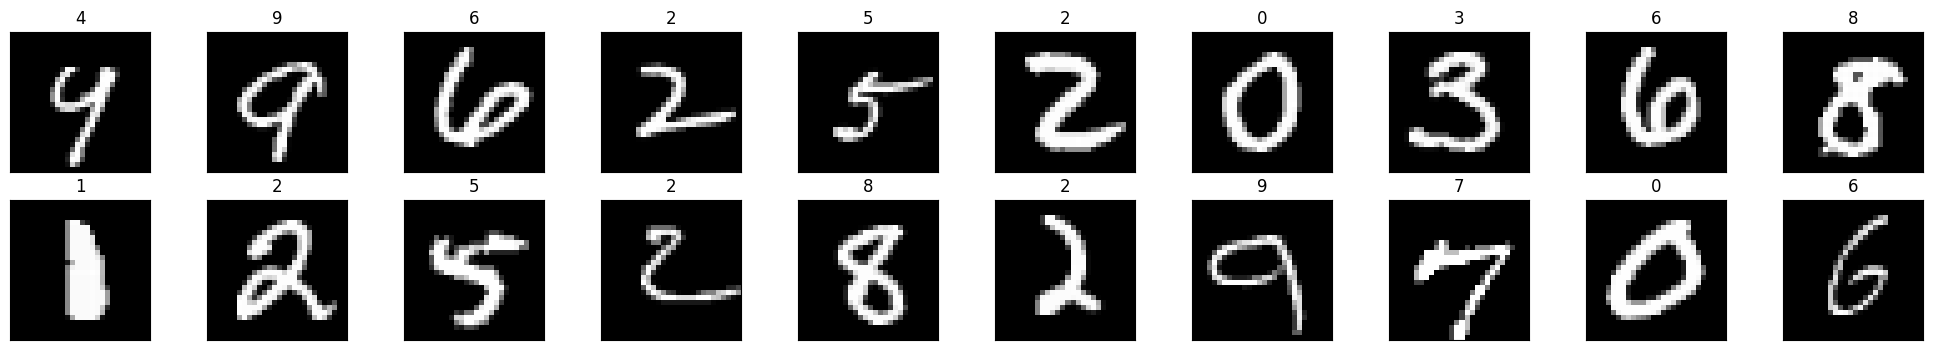

In [7]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
%matplotlib inline

for images, labels in train_loader:
    images = images.numpy()
    fig = plt.figure(figsize=(25, 4))

    for idx in np.arange(batch_size):
        ax = fig.add_subplot(2, int(batch_size/2), idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title(str(labels[idx].item()))
    break

## View an Image in More Detail

Here, we look at one sample in a batch to see the pixel values (intensities). Note that our images are grayscale (even if the dataset were in RGB, the color data was irrelevant!) because for detecting the handwritten digits, the color of the ink of pen is not important (obviously)!

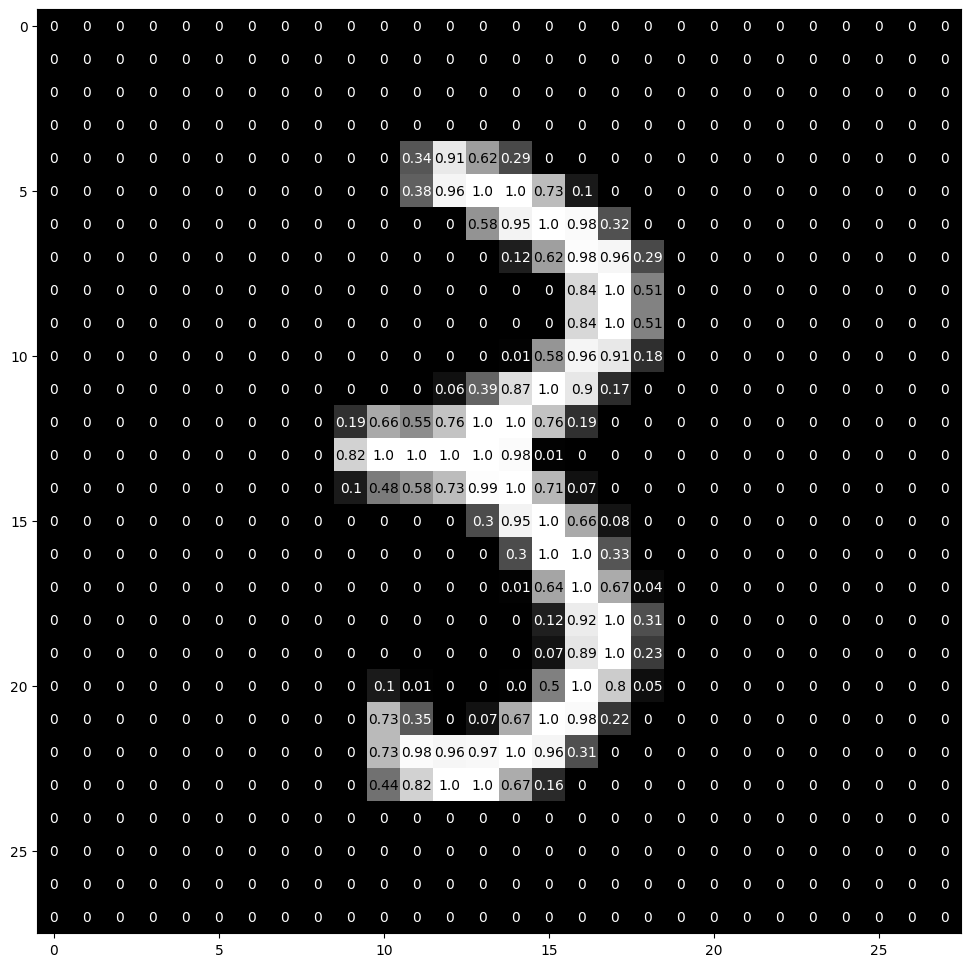

In [8]:
for images, labels in train_loader:
    images = images.numpy()

    idx = 0
    img = np.squeeze(images[idx])

    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')
    break

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

In this cell, you should define the network architecture. Note the dimensions of the input (print it out!) and the outputs. Your output should be a tensor of length 10 (digits 0 to 9) that indicates scores (probabilities) for an input image belonging to that class [$P(C_i|x)$]. Use `Drop out` layers to avoid overfitting!

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()
print(model)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = ConvNet()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


##  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Here you should define the loss function used in training process and the optimizer. We recommend you use `cross-entropy` loss. But you can explore other loss functions if you think they work better in this case! Also, you can use `SGD` or `Adam` optimizer, or any other optimizers that you think would work better!

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Complete the code below:

In [12]:
n_epochs = 30

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    model = model.cuda()

for epoch in range(n_epochs):
    train_loss = 0.0

    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.124197
Epoch: 2 	Training Loss: 0.042891
Epoch: 3 	Training Loss: 0.028544
Epoch: 4 	Training Loss: 0.022724
Epoch: 5 	Training Loss: 0.017763
Epoch: 6 	Training Loss: 0.015746
Epoch: 7 	Training Loss: 0.011278
Epoch: 8 	Training Loss: 0.010187
Epoch: 9 	Training Loss: 0.008529
Epoch: 10 	Training Loss: 0.008470
Epoch: 11 	Training Loss: 0.007375
Epoch: 12 	Training Loss: 0.007616
Epoch: 13 	Training Loss: 0.004902
Epoch: 14 	Training Loss: 0.005514
Epoch: 15 	Training Loss: 0.006084
Epoch: 16 	Training Loss: 0.004872
Epoch: 17 	Training Loss: 0.004642
Epoch: 18 	Training Loss: 0.004010
Epoch: 19 	Training Loss: 0.004862
Epoch: 20 	Training Loss: 0.003908
Epoch: 21 	Training Loss: 0.004082
Epoch: 22 	Training Loss: 0.004069
Epoch: 23 	Training Loss: 0.003645
Epoch: 24 	Training Loss: 0.003463
Epoch: 25 	Training Loss: 0.004402
Epoch: 26 	Training Loss: 0.003015
Epoch: 27 	Training Loss: 0.003785
Epoch: 28 	Training Loss: 0.002812
Epoch: 29 	Training Loss: 0.0

---
## Test the Trained Network

And at last, you should test the model on test_set (previously unseen data). We will use test_set to evaluate the model's performance. Don't forget to prepare the model for evaluation(testing) using `model.eval()` in Pytorch!

You should report the Test Accuracy of your model.

In [13]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
for data, target in test_loader:
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.075133

Test Accuracy of     0: 99% (978/980)
Test Accuracy of     1: 99% (1132/1135)
Test Accuracy of     2: 98% (1017/1032)
Test Accuracy of     3: 99% (1004/1010)
Test Accuracy of     4: 99% (973/982)
Test Accuracy of     5: 98% (879/892)
Test Accuracy of     6: 98% (944/958)
Test Accuracy of     7: 99% (1020/1028)
Test Accuracy of     8: 98% (962/974)
Test Accuracy of     9: 99% (1005/1009)

Test Accuracy (Overall): 99% (9914/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

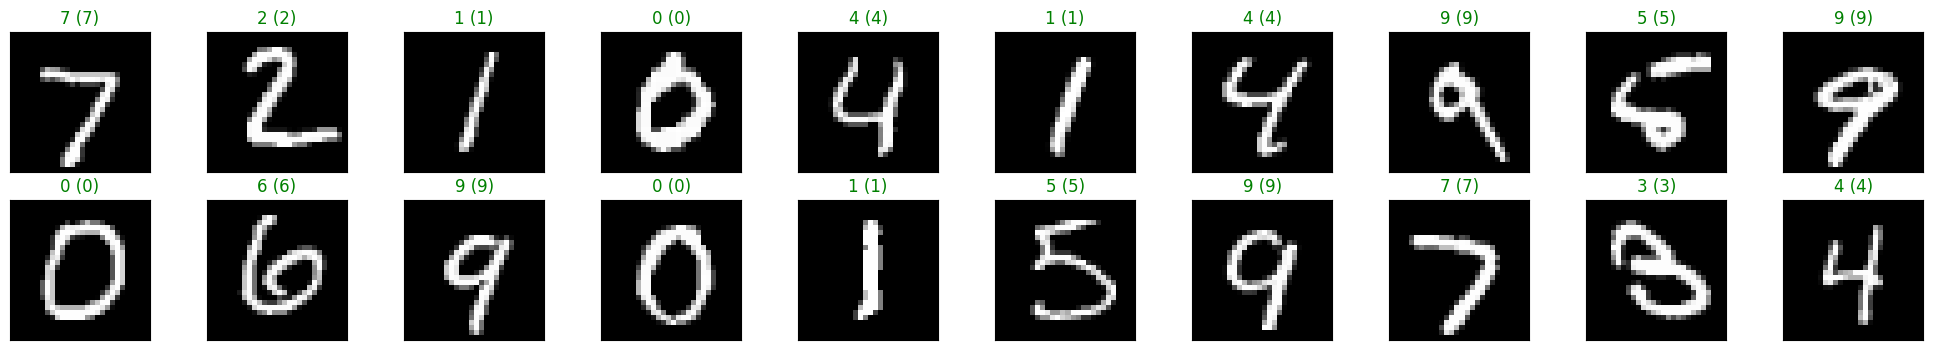

In [17]:
images, labels = next(iter(test_loader))

if torch.cuda.is_available():
    images, labels = images.cuda(), labels.cuda()
output = model(images)
_, preds = torch.max(output, 1)
images = images.cpu().numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))